In [93]:
import os
import time
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm


import opensmile


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

import torch
from torch import nn
import torch.nn.functional as F

from tensorflow.keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD




In [94]:
files = glob(r'data/Audio_Speech_Actors_01-24/*/*.wav')

smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)
dataset = smile.process_files(files)

x = dataset.values
y = np.array([int(os.path.basename(path).split('-')[2]) for path in files])




In [95]:
enc = OneHotEncoder(sparse_output=False)  
y_hot = enc.fit_transform(y.reshape(-1, 1)) 
print(y_hot)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


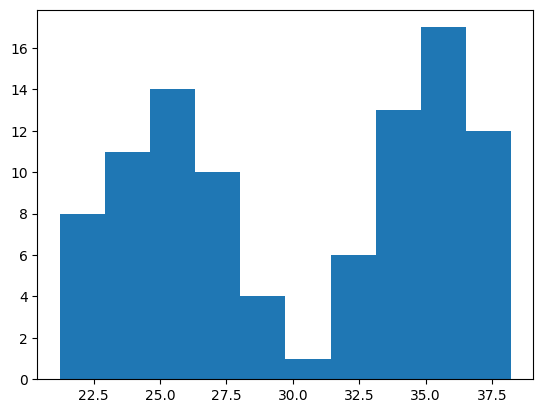

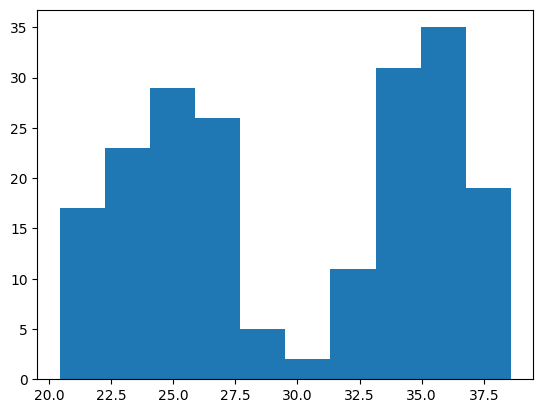

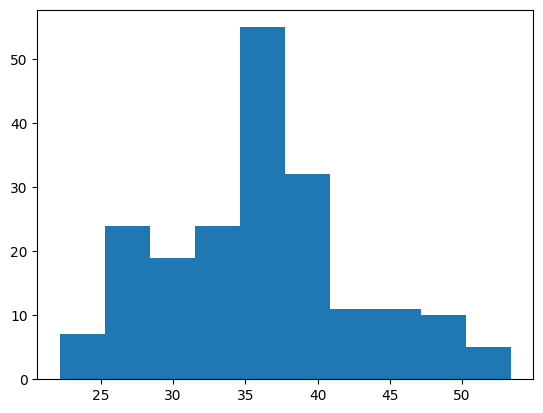

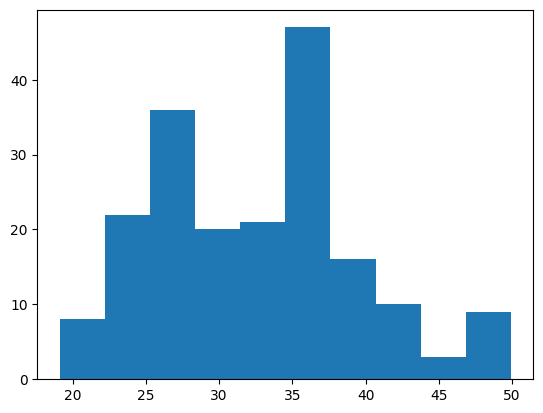

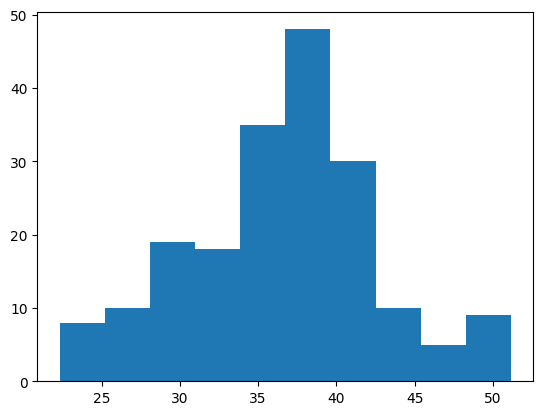

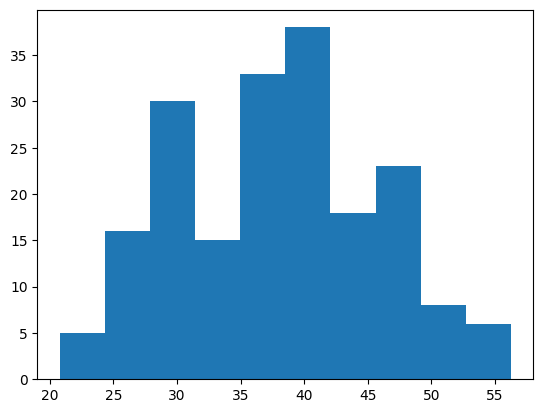

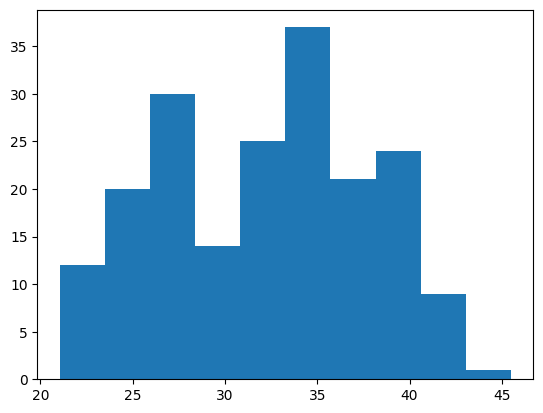

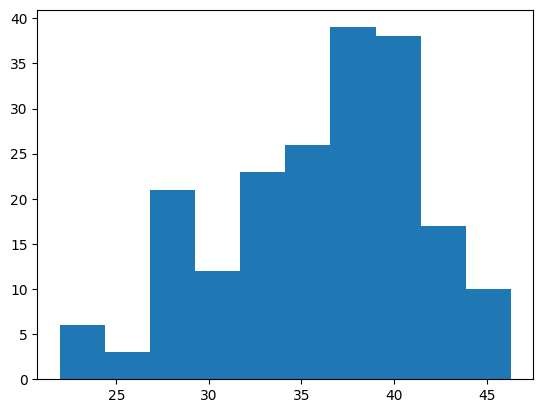

In [96]:
#print(dataset)
for i in range(1, 9):
    plt.hist(dataset['F0semitoneFrom27.5Hz_sma3nz_amean'][y==i])
    plt.show()



## Filename identifiers 

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [98]:
def normalization(X, mean, std):
    return (X-mean)/std

In [101]:
x_train, x_test, y_train, y_test = train_test_split(x, y)
print(x_train.shape)
print(y_train.shape)

x_train_norm = normalization(x_train, np.mean(x_train, axis=0), np.std(x_train, axis=0))
x_test_norm = normalization(x_test, np.mean(x_train, axis=0), np.std(x_train, axis=0))
print(x_train_norm.shape)
print(x_test_norm.shape)


(1092, 88)
(1092,)
(1092, 88)
(364, 88)


## Random Forest

In [ ]:
num_trees = range(50, 200)
for n in num_trees:
    random_forest = RandomForestClassifier(n_estimators=n, random_state= 32)
    random_forest.fit(x_train, y_train)
    y_predict = random_forest.predict(x_test)
    acc = accuracy_score(y_test, y_predict)
    print(f"{n} trees --> Accuracy {acc}")



50 trees --> Accuracy 0.5824175824175825
51 trees --> Accuracy 0.5741758241758241
52 trees --> Accuracy 0.5741758241758241
53 trees --> Accuracy 0.5741758241758241
54 trees --> Accuracy 0.5741758241758241
55 trees --> Accuracy 0.5659340659340659
56 trees --> Accuracy 0.5686813186813187
57 trees --> Accuracy 0.5796703296703297
58 trees --> Accuracy 0.5741758241758241
59 trees --> Accuracy 0.5824175824175825
60 trees --> Accuracy 0.5769230769230769
61 trees --> Accuracy 0.5824175824175825
62 trees --> Accuracy 0.5851648351648352
63 trees --> Accuracy 0.5851648351648352
64 trees --> Accuracy 0.5851648351648352
65 trees --> Accuracy 0.5879120879120879
66 trees --> Accuracy 0.5851648351648352
67 trees --> Accuracy 0.5961538461538461
68 trees --> Accuracy 0.5934065934065934
69 trees --> Accuracy 0.5879120879120879
70 trees --> Accuracy 0.5906593406593407
71 trees --> Accuracy 0.5906593406593407
72 trees --> Accuracy 0.5961538461538461
73 trees --> Accuracy 0.6098901098901099
74 trees --> Acc

In [102]:
class MLPAutoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(MLPAutoencoder, self).__init__()
        #self.flatten = nn.Flatten()
        self.encoder = nn.Linear(88, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, 88)
        #self.unflatten = torch.nn.Unflatten(1, 88)

    def forward(self, x):
        #x = self.flatten(x)
        out = F.relu(self.encoder(x))
        out = torch.sigmoid(self.decoder(out))
        return out
    
    def get_embedding(self, x):
        #x = self.flatten(x)
        return F.relu(self.encoder(x))
d = torch.from_numpy(dataset.values)
print(d.shape)
print(nn.Flatten(d))
print(d[0].shape)

torch.Size([1456, 88])
Flatten(
  start_dim=tensor([[ 24.2639,   0.1042,  21.6535,  ...,   0.5400,   0.4803, -47.9396],
          [ 25.1679,   0.1036,  23.1782,  ...,   0.5350,   0.4852, -47.3423],
          [ 24.1866,   0.1035,  22.3539,  ...,   0.6767,   0.4148, -45.8498],
          ...,
          [ 45.1380,   0.1604,  38.2045,  ...,   0.3967,   0.4685, -35.4364],
          [ 43.1945,   0.0982,  40.3045,  ...,   0.3567,   0.3475, -32.8926],
          [ 44.3718,   0.1127,  39.8030,  ...,   0.3583,   0.4197, -33.3745]]), end_dim=-1
)
torch.Size([88])


In [ ]:
model = MLPAutoencoder(dataset.shape[1])
pred = model(d)


tensor([1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 9.0550e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.1291e-16, 1.0000e+00, 1.4223e-28,
        2.9941e-10, 2.8708e-25, 1.0000e+00, 4.2171e-25, 1.0000e+00, 1.0000e+00,
        2.9714e-26, 1.0000e+00, 1.0000e+00, 9.9284e-15, 6.4196e-29, 4.4288e-33,
        1.5515e-06, 1.6487e-05, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0300e-21,
        1.6495e-21, 1.8707e-33, 1.0000e+00, 1.0000e+00, 1.0000e+00, 3.7224e-10,
        3.7602e-39, 1.0000e+00, 4.3486e-02, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        6.6054e-38, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 2.9111e-25,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        9.9894e-01, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        9.9756e-01, 2.5251e-13, 0.0000e+00, 1.0000e+00, 1.0000e+00, 9.9996e-01,
        1.0000e+00, 1.0000e+00, 5.0581e-34, 1.0000e+00, 1.0000e+00, 5.1280e-06,
        1.0000e+00, 0.0000e+00, 1.0000e+

100%|██████████| 20/20 [00:56<00:00,  2.83s/it]


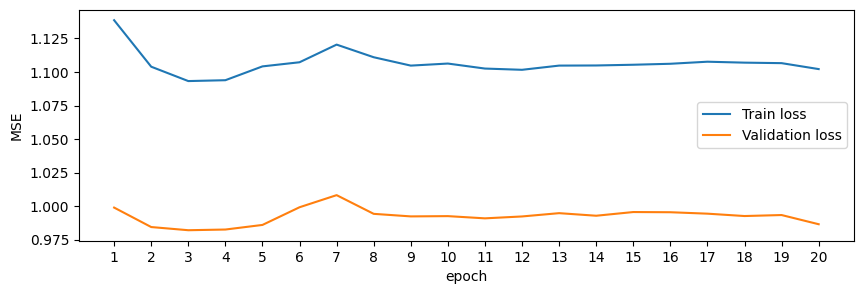

In [103]:
LR = 0.1
device = "cpu"
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

n_epochs = 20
model.to(device)
t_losses, v_losses = [], []
x_train_tensor = torch.from_numpy(x_train_norm)
x_test_tensor = torch.from_numpy(x_test_norm)

for epoch in tqdm(range(1, n_epochs+1)):
    # Training
    train_loss = 0.0
    for (X, y) in zip(x_train_tensor, y_train):
        X = torch.squeeze(X).to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, X)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
            
    # Eval        
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for (X, y) in zip(x_test_tensor, y_test):
            X = torch.squeeze(X).to(device)
            outputs = model(X)
            loss = criterion(outputs, X)
            test_loss += loss.item()        
            
    train_loss = train_loss/len(x_train)
    test_loss = test_loss/len(x_test)
    t_losses.append(train_loss)
    v_losses.append(test_loss)
    
plt.figure(figsize=(10,3))
plt.plot(np.arange(1,len(t_losses)+1), t_losses, label='Train loss')
plt.plot(np.arange(1,len(v_losses)+1),v_losses, label='Validation loss')
plt.xticks(np.arange(1,len(t_losses)+1))
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend()
plt.show()